In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, generate_laser_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute()

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [908]:
Js_g = [1] # J values to be included

parity = lambda J: (-1)**J

# generate a list of approximate ground states
# ground_states_approx = generate_coupled_ground_states(Js_g, electronic_state = 'X',
#                                                        parity = parity, Ω = 0, I_Tl = 1/2, 
#                                                        I_F = 1/2)
# ground_states_approx = [1*state for state in ground_states_approx]

I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_ground = [1,1,1,1]
F1_ground = [1/2,1/2,3/2,3/2]
F_ground = [0,1,1,2]
# J_ground = [1]
# F1_ground = [1/2]
# F_ground = [1]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1**J), Omega = 0)
                  for J,F1,F in zip(J_ground, F1_ground, F_ground)
                  for mF in ni_range(-F, F+1)
                 ]

In [909]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [910]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [911]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [912]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [1/2]
F_excited = [0]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [913]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [914]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [915]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [916]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [917]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
# excited_states_laser_approx = [1*CoupledBasisState(
#                                 F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
#                                 )
#                             ]
excited_states_laser_approx = excited_states_approx

In [918]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = +1, Omega = 1)

In [919]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [920]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0

In [921]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.4990839316055246+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [922]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

## Total Hamiltonian

In [923]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1

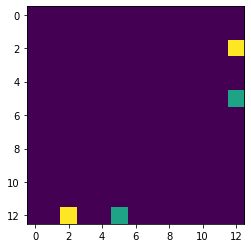

In [924]:
plt.imshow(H_laser_z_1.real)

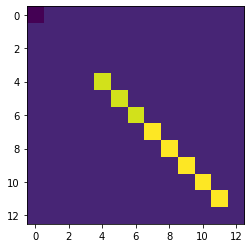

In [925]:
plt.imshow(H_rot.real)

In [926]:
np.diag(D1)

array([0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       9.28906346e+10+0.j])

In [928]:
np.diag(H_rot.real)/(2*np.pi)

array([-2.22387832e+04,  1.70277770e+00,  0.00000000e+00, -1.70329983e+00,
        1.75952406e+05,  1.75952434e+05,  1.75952463e+05,  1.90494496e+05,
        1.90492857e+05,  1.90491217e+05,  1.90489578e+05,  1.90487938e+05,
        0.00000000e+00])

In [929]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.48it/s]


In [930]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1)]
detunings = [[QN.index(excited_states[0])]]

In [931]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [934]:
H_symbolic

Matrix([
[-139730.395599365,                            0,               0,                             0,                            0,                            0,                             0,                0,                0,                0,                0,                0,                            0],
[                0,             10.6988677978516,               0,                             0,                            0,                            0,                             0,                0,                0,                0,                0,                0,  0.353552889856896*Ω1*Px1(t)],
[                0,                            0,               0,                             0,                            0,                            0,                             0,                0,                0,                0,                0,                0,               -0.5*Ω1*Pz1(t)],
[                0,                            0,            

In [935]:
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωs[0][0]).subs(Ωs[1][1],Ωs[0][1])
H_symbolic

Matrix([
[-139730.395599365,                            0,               0,                             0,                            0,                            0,                             0,                0,                0,                0,                0,                0,                            0],
[                0,             10.6988677978516,               0,                             0,                            0,                            0,                             0,                0,                0,                0,                0,                0,  0.353552889856896*Ω1*Px1(t)],
[                0,                            0,               0,                             0,                            0,                            0,                             0,                0,                0,                0,                0,                0,               -0.5*Ω1*Pz1(t)],
[                0,                            0,            

In [936]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.73it/s]


In [937]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [938]:
# import julia
# julia.install()

In [939]:
from julia import Main

In [940]:
Main.eval("""
using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < 6:
    Main.eval("""
    addprocs(6)

    @everywhere begin
        using LinearAlgebra
        using Trapz
        using DifferentialEquations
        include("utils/general_ode_functions.jl")
    end
    """)

In [941]:
procs = Main.eval("procs()")
if len(procs) > 6:
    for p in procs[procs>6]:
        Main.eval(f"rmprocs({p})")

In [942]:
# Px = Main.eval("[sine_wave(ti, νp1, 4.71238898038469) for ti = range(0,1/νp1,length=101)]")
# Pz = Main.eval("[sine_wave(ti, νp1, 1.5707963267948966) for ti = range(0,1/νp1,length=101)]")
# normalization = np.sqrt(Px**2+Pz**2)
# plt.plot(np.array([Px,Pz]).T/normalization[:,np.newaxis])

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [943]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ1 = p[1]
\t\tνp1 = p[2]
\t\tΔ = p[3]
\t\tΩ1ᶜ = conj(Ω1)
\t\tPx1 = sine_wave(t, νp1, 4.71238898038469)
\t\tPz1 = sine_wave(t, νp1, 1.5707963267948966)
\t\tnorm1 = sqrt(Px1^2+Pz1^2)
\t\tPx1 /= norm1
\t\tPz1 /= norm1
"""

In [944]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω1 = p[1]
		νp1 = p[2]
		Δ = p[3]
		Ω1ᶜ = conj(Ω1)
		Px1 = sine_wave(t, νp1, 4.71238898038469)
		Pz1 = sine_wave(t, νp1, 1.5707963267948966)
		norm1 = sqrt(Px1^2+Pz1^2)
		Px1 /= norm1
		Pz1 /= norm1



In [945]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [946]:
with open('ode_amherst_cyling_F0.jl', 'w', encoding='utf8') as f:
    f.write(ode_fun)

In [947]:
# reading from file
with open('ode_amherst_cyling_F0.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [948]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

In [949]:
ρ_ini = np.zeros([n_states, n_states], dtype = complex)
np.fill_diagonal(ρ_ini[:n_states-1, :n_states-1], 1/(n_states-1))

In [950]:
Γ = 2*np.pi * 1.56e6
Ω1 = Γ
ωp1 = 2*np.pi*2e6 # 2 MHz
Δ1 = 0
ωp1 = 0*np.pi*2e6

νp1 = ωp1/(2*np.pi)

Main.Γ = Γ
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ1 = Δ1

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ω1 = Γ
    Δ1 = 0
    @eval @everywhere νp1 = $νp1
    p = [Ω1, νp1, Δ1]
end
""")

In [952]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 1.94 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [953]:
Main.eval("""
tspan = (0.0f0, 2*25.4/1e3 / 184)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [954]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, dt = 1e-9)
tmp = 0
""");

Wall time: 1.36 s


0

In [955]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

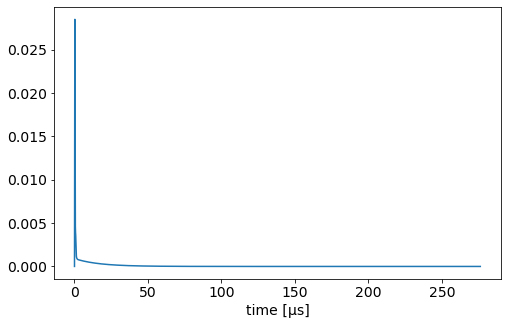

In [956]:
exc_F0 = pop_results[-1,:]

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, exc_F0)

ax.set_xlabel('time [μs]')

set_fontsize(ax, 14)

In [957]:
np.trapz(exc_F0, t_array/1e6)*Γ

0.24370694235719687

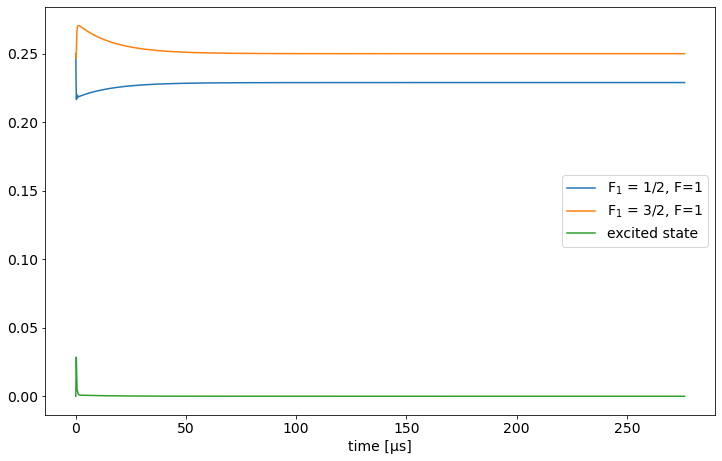

In [958]:
fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t_array, np.sum(pop_results[:3,:], axis = 0), label = r'F$_1$ = 1/2, F=1')
ax.plot(t_array, np.sum(pop_results[3:6,:], axis = 0), label = r'F$_1$ = 3/2, F=1')
ax.plot(t_array, np.sum(pop_results[-1:], axis = 0), label = 'excited state')

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [959]:
for s in QN:
    s.print_state()

+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2

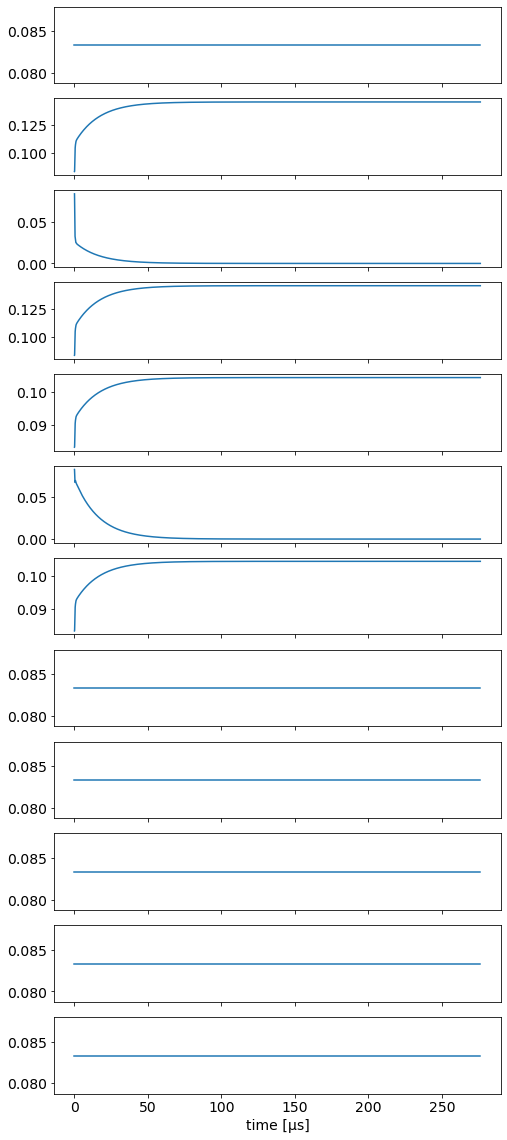

In [962]:
fig, axes = plt.subplots(figsize = (8,20), nrows = 12, sharex = True)
for idx, pop in enumerate(pop_results[:-1]):
    axes[idx].plot(t_array, pop)

axes[idx].set_xlabel('time [μs]')
for ax in axes:
    set_fontsize(ax, 14)

### Parameter scan for polarization switching frequency

In [963]:
Main.eval("""
@everywhere params = [val*Γ/(2pi) for val in 0:5/401:5]""")
# Main.params = Main.νs

In [964]:
# defining a progress bar to keep track of the ODE ensemble solver progress
# Main.eval("using ProgressMeter")
# Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

In [965]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[{n_states}])) for j in 1:size(sol.u)[1]]), false
end""")

In [966]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [967]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[Ω1; params[i]; Δ1])
end
""")

In [968]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""")

<PyCall.jlwrap EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}(ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}(ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, N

In [969]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

11.4948401

In [970]:
results_νs = Main.eval("sim.u")

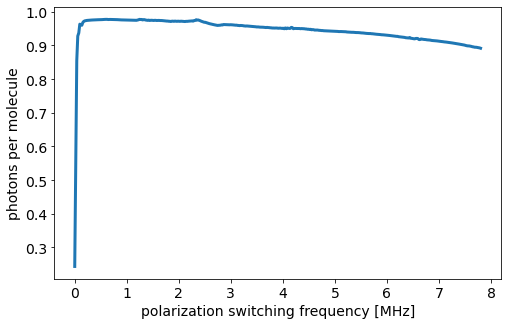

In [971]:
νs = Main.params
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(νs/1e6, results_νs*Γ, lw = 3)
ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

In [972]:
νs[np.argmax(results_νs)]

622443.8902743142

### Parameter scan for Ω

In [973]:
Main.eval("@everywhere params = [val*Γ for val in 0:3/101:3]")

In [974]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[{n_states}])) for j in 1:size(sol.u)[1]]), false
end""")

In [975]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [976]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i]; 2769000.0; Δ1])
end
""")

In [977]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""")

<PyCall.jlwrap EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}(ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}(ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, N

In [978]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

1.4774725

In [979]:
results_Ωs = Main.eval("sim.u")

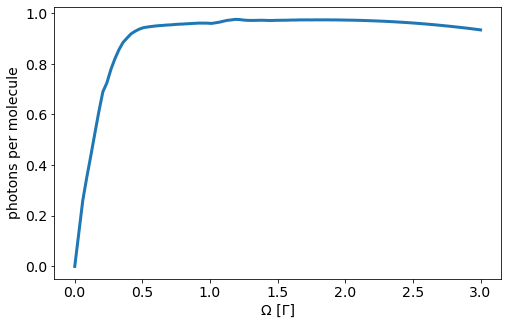

In [980]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, results_Ωs*Γ, lw = 3)
ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

### Parameter scan for Δ

In [981]:
Main.eval("@everywhere params = [val*2pi*1e6 for val in range(-25,25,length=801)]")

In [982]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p);
""");

In [983]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[1Γ; 0.0; params[i]; 1Γ])
end
""")

In [984]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [985]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-11, reltol = 1e-8)
sim.elapsedTime
""")

38.4195096

In [986]:
results_Δs = Main.eval("sim.u")

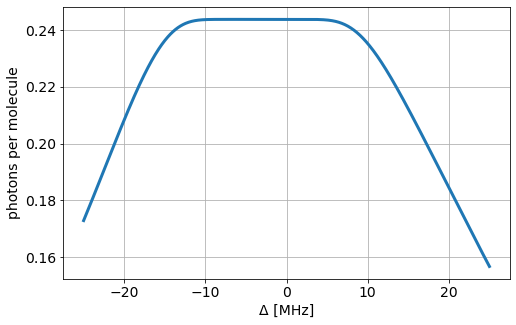

In [987]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), results_Δs*Γ, lw = 3)
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.grid(True)
set_fontsize(ax, 14)

In [740]:
Main.params[np.argmax(results_Δs)]/(2*np.pi*1e3)

-7812.499999999999

In [741]:
H_laser_z_1[np.nonzero(H_laser_z_1)]

array([0.49908393+0.j, 0.29025602+0.j, 0.49908393+0.j, 0.29025602+0.j])

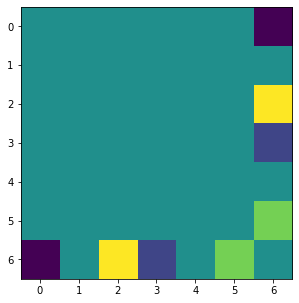

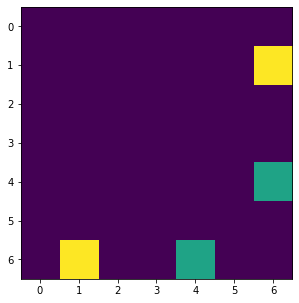

In [742]:
fig, ax = plt.subplots(figsize = (8,5))
ax.imshow(H_laser_x_1.real)
fig, ax = plt.subplots(figsize = (8,5))
ax.imshow(H_laser_z_1.real)

In [743]:
for arr in C_array:
    print(np.nonzero(arr))

(array([0], dtype=int64), array([6], dtype=int64))
(array([1], dtype=int64), array([6], dtype=int64))
(array([2], dtype=int64), array([6], dtype=int64))
(array([3], dtype=int64), array([6], dtype=int64))
(array([4], dtype=int64), array([6], dtype=int64))
(array([5], dtype=int64), array([6], dtype=int64))


In [744]:
np.diag(H_rot).real/(2*np.pi*1e6)

array([-1.75950732e-01, -1.75952434e-01, -1.75954138e-01, -2.84160155e-08,
        0.00000000e+00,  2.85082989e-08,  0.00000000e+00])

In [750]:
import numpy as np
from sympy import Symbol
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations

ωa = Symbol('ω_a', real = True)
ωb = Symbol('ω_b', real = True)
ωd = Symbol('ω_d', real = True)
ωE = Symbol('ω_E', real = True)

ω_F1mF0 = Symbol('ω_F1mF0', real = True)
Ω_F1mF0 = Symbol('Ω_F1mF0', real = True)
ω_F0mF0  = Symbol('ω_F0mF0 ', real = True)
Ω_F0mF0 = Symbol('Ω_F0mF0', real = True)

Δ1 = Symbol('Δ1', real = True)

ham = Hamiltonian(7)
ham.addEnergies([ωa, ωa, ωa, ωb, ωb, ωb, ωE])
ham.addCoupling(1,6,Ω_F0mF0,ω_F0mF0)
ham.addCoupling(4,6,Ω_F1mF0,ω_F1mF0)
ham.eqnTransform()
ham.defineZero(ωE)
ham.defineStateDetuning(1,6,Δ1)
ham.defineStateDetuning(4,6,Δ1)

In [751]:
ham.transformed

Matrix([
[ω_a,          0,   0,   0,          0,   0,          0],
[  0,    -1.0*Δ1,   0,   0,          0,   0, -Ω_F0mF0/2],
[  0,          0, ω_a,   0,          0,   0,          0],
[  0,          0,   0, ω_b,          0,   0,          0],
[  0,          0,   0,   0,    -1.0*Δ1,   0, -Ω_F1mF0/2],
[  0,          0,   0,   0,          0, ω_b,          0],
[  0, -Ω_F0mF0/2,   0,   0, -Ω_F1mF0/2,   0,          0]])

In [752]:
H_laser_z_1[np.nonzero(H_laser_z_1)]

array([0.49908393+0.j, 0.29025602+0.j, 0.49908393+0.j, 0.29025602+0.j])

In [ ]:
ME_main_1

In [753]:
np.nonzero(H_laser_z_1)

(array([1, 4, 6, 6], dtype=int64), array([6, 6, 1, 4], dtype=int64))

In [754]:
dis = Dissipator(ham.transformed.shape[0])
decays = [Symbol(f'Γ{i}', real = True) for i in range(len(C_array))]
for arr, decay in zip(C_array, decays):
    ind1, ind2 = np.nonzero(arr)
    ind1 = ind1[0]
    ind2 = ind2[0]
    dis.addDecay(ind2, ind1, decay)

In [755]:
bloch = BlochEquations(ham.transformed.shape[0], dis.density_matrix, ham.transformed, dis.dissipator)

In [757]:
replacements = []
for decay, arr in zip(decays, C_array):
    d = (arr[np.nonzero(arr)][0].real)**2/Γ
    replacements.append((decay,d))
replacements.append((ωa,0))
replacements.append((ωb,176*1e3*2*np.pi))
replacements.append((Ω_F0mF0, 0.01*Γ*0.49908393/(2*ME_main_1)))
replacements.append((Ω_F1mF0, 0.01*Γ*0.29025602/(2*ME_main_1)))

In [777]:
replacements = []
for decay, arr in zip(decays, C_array):
    replacements.append((decay,1/2))
replacements.append((ωa,0))
replacements.append((ωb,0.5))
replacements.append((Ω_F0mF0, 10))
replacements.append((Ω_F1mF0, 10*0.5/0.3))

In [778]:
nstates = ham.transformed.shape[0]
ρ = np.zeros([nstates,nstates], dtype = 'complex')
np.fill_diagonal(ρ[:nstates-1, :nstates-1], 1/(nstates-1))
ρ = ρ.flatten()

Wall time: 1.25 s


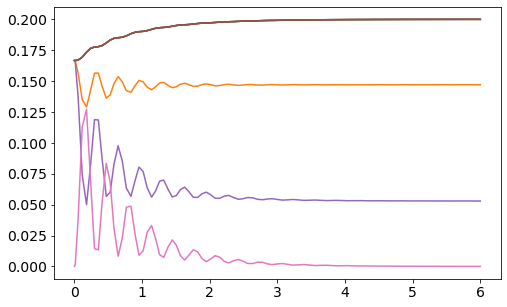

In [779]:
%%time

r = copy.copy(replacements)
r.append((Δ1, 0))
sol = bloch.solveNumeric(r, (0,6), ρ)

fig, ax = plt.subplots(figsize = (8,5))
for i in range(nstates):
    ax.plot(sol.t, sol.y[(nstates+1)*i].real)

set_fontsize(ax, 14)

In [784]:
import copy
results = []

scan_Δ = np.linspace(-30,30,51)
for Δ in tqdm(scan_Δ):
    r = copy.copy(replacements)
    r.append((Δ1, Δ))
    sol = bloch.solveNumeric(r, (0,6), ρ)
    results.append(np.trapz(sol.y[-1,:].real))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:03<00:00,  1.24s/it]


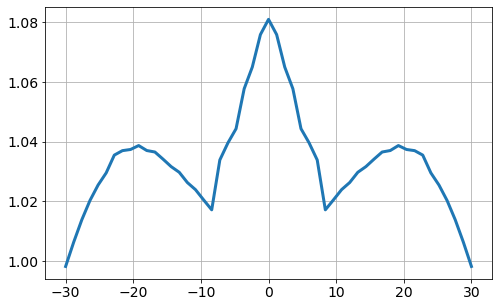

In [785]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(scan_Δ, np.array(results), lw = 3)

ax.grid(True)
set_fontsize(ax, 14)

In [649]:
(scan_Δ/(2*np.pi*1e6))[np.argmax(results)]

0.0